In [27]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Unset the environment variables if they are set
if "OPENAI_API_KEY" in os.environ:
    del os.environ["OPENAI_API_KEY"]
if "MONGODB_URI" in os.environ:
    del os.environ["MONGODB_URI"]

# Load environment variables from the .env file and explicitly reload them
load_dotenv(override=True)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/'))
sys.path.append(root_path_scripts)
root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/advance_rag_pipeline'))
sys.path.append(root_path_scripts)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/visualize_advance_rag_pipeline'))
sys.path.append(root_path_scripts)
# root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/visualize_advance_rag_pipeline'))
# sys.path.append(root_path_scripts)

In [28]:
import umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from advance_rag_pipeline.retrieval import add_documents_to_vector_store, load_embeddings_from_db
from advance_rag_pipeline.generator import generate_response,get_retriever
from advance_rag_pipeline.evaluator import load_evaluation_data, evaluate_responses, print_evaluation_results
from advance_rag_pipeline.evaluation2 import generate_responses, prepare_dataset, evaluate_dataset

from advance_rag_pipeline.visualize import project_embeddings, visualize_embeddings
from load_split_data.load_split import load_document, split_document
from visualize_advance_rag_pipeline.retrieval import load_embeddings_from_db, query_relevant_documents, vector_store, embeddings_model
from visualize_advance_rag_pipeline.generator import augment_multiple_query, llm
from pymongo import MongoClient
from pymongo.server_api import ServerApi
# Load environment variables from the .env file
load_dotenv(find_dotenv())
# # Load and split the document
# file_path = '../data/short_contracts/Robinson_Advisory.docx'  # Change to your document path
# data = load_document(file_path)
# chunks = split_document(data)

# # Add chunks to the vector store
# add_documents_to_vector_store(chunks)



True

In [29]:
# Retrieve environment variables
db_uri = os.getenv("MONGODB_URI")

# Database configuration
client = MongoClient(db_uri, server_api=ServerApi('1'))

# Updated database and collection names
LizzyAI_ContractsDB = client["LizzyAI_Contracts"]
lizzyai_collection = LizzyAI_ContractsDB["contracts"]

# Load embeddings from MongoDB
embeddings, documents = load_embeddings_from_db(lizzyai_collection)

# UMAP transformation
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


/home/air/week11/.week11/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 325/325 [04:45<00:00,  1.14it/s]


## Visualition Robinson embedding data

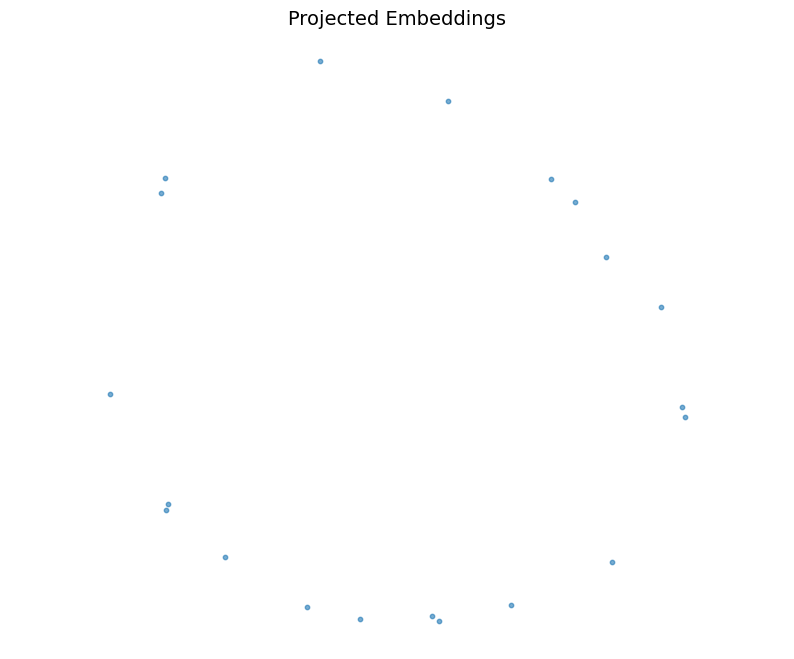

In [5]:

# Visualization of the dataset embeddings
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings', fontsize=14)
plt.axis('off')
plt.show()


## Visualition Raptor embedding data

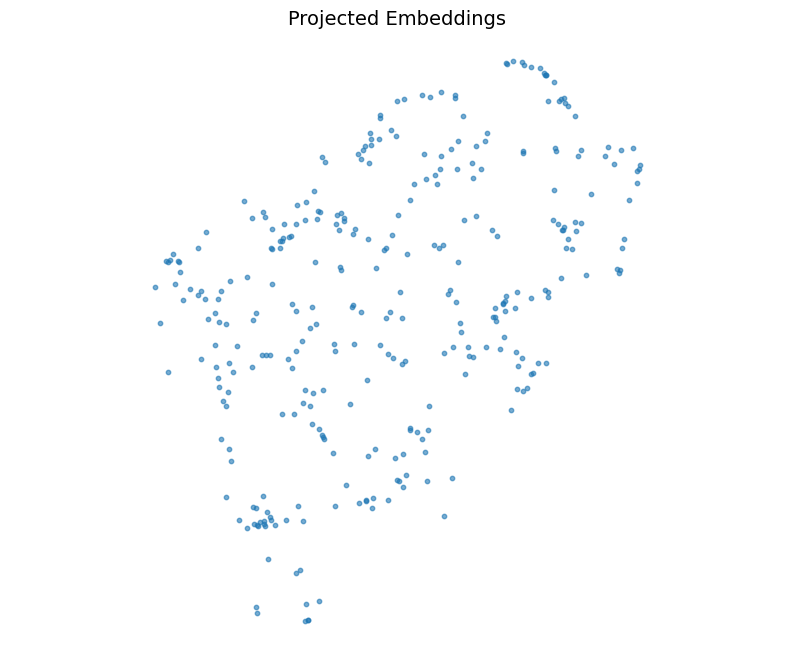

In [30]:

# Visualization of the dataset embeddings
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings', fontsize=14)
plt.axis('off')
plt.show()


## Augmented Query Embeddings, Retrivied Embeddings and Original Query for Robinson

In [6]:

# Example query
original_query =  "What is the termination notice?"

# Augment the query with multiple related questions
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

queries = [original_query] + augmented_queries

# Retrieve documents using the expanded queries
retrieved_documents, retrieved_embeddings = query_relevant_documents(queries, vector_store)

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)


# Retrieve embeddings for visualization
original_query_embedding = embeddings_model.embed_query(original_query)
augmented_query_embeddings = embeddings_model.embed_documents(augmented_queries)

project_original_query = project_embeddings([original_query_embedding], umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

# Flatten the list of embeddings
result_embeddings = [embedding for sublist in retrieved_embeddings for embedding in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


/home/air/week11/.week11/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


content='What type of contract are you inquiring about?\nWhat is the duration of the contract?\nAre there any specific clauses in the contract you need help with?\nWhat are the obligations and rights of each party in the contract?\nAre there any penalties for breach of contract?' response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 100, 'total_tokens': 153}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-054e84fa-c8ff-4c06-b755-d386d94d50be-0' usage_metadata={'input_tokens': 100, 'output_tokens': 53, 'total_tokens': 153}
What type of contract are you inquiring about?
What is the duration of the contract?
Are there any specific clauses in the contract you need help with?
What are the obligations and rights of each party in the contract?
Are there any penalties for breach of contract?


/home/air/week11/.week11/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


## Visualize The Dataset, Augmented Query Embeddings, Retrivied Embeddings and Original Query for Robinson data

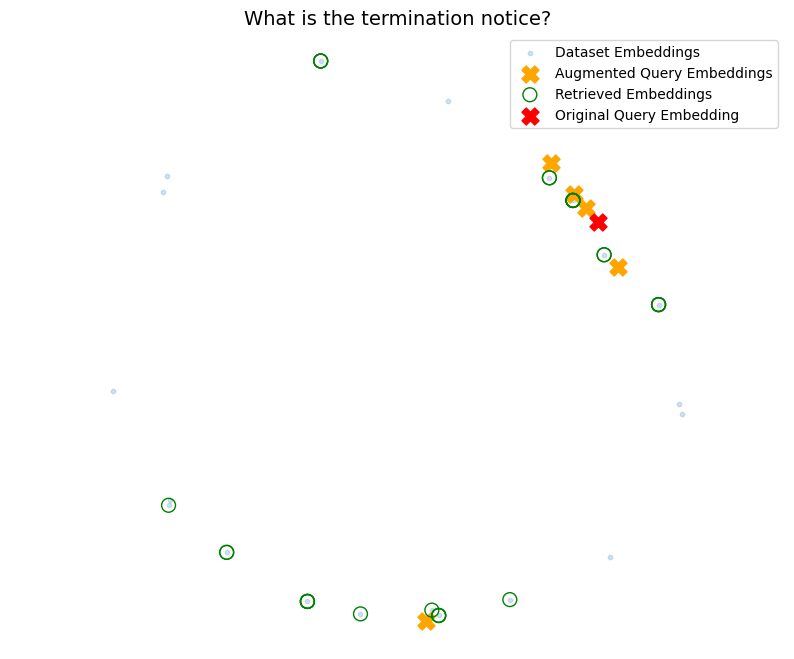

In [7]:

# Plot the projected queries and retrieved documents in the embedding space
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.2, label='Dataset Embeddings')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange', label='Augmented Query Embeddings')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Retrieved Embeddings')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r', label='Original Query Embedding')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}', fontsize=14)
plt.legend()
plt.axis('off')
plt.show()


## Evaluate using Ragas

In [18]:


# Load the evaluation dataset
evaluation_data = load_evaluation_data('evaluation_dataset.json')

# # Initialize a list to store all the responses
# responses = []

# # Loop through each question in the evaluation dataset
# for item in evaluation_data:
#     question = item['question']
#     ground_truth = item['answer']

#     # Generate a response
#     response = generate_response(question)
    
#     # Store the response and ground truth
#     responses.append({
#         'query': question,
#         'result': response['result'],
#         'source_documents': response['source_documents'],
#         'ground_truths': [ground_truth]
#     })

# # Evaluate the responses
# evaluation_results = evaluate_responses(responses)

# # Print evaluation results
# print_evaluation_results(evaluation_results)


## 2 Method Two

In [19]:

# Generate responses
responses = generate_responses(evaluation_data)

# Prepare the dataset
dataset = prepare_dataset(responses)

# Verify the dataset
print(dataset)

# Evaluate the dataset
evaluation_results = evaluate_dataset(dataset)

# Print the evaluation results
print(evaluation_results)


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 10
})
evaluating with [context_precision]


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


evaluating with [faithfulness]


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


evaluating with [answer_relevancy]


100%|██████████| 1/1 [00:12<00:00, 12.25s/it]


                                                                                             question  \
0                              Who are the parties to the Agreement and what are their defined names?   
1                                                                     What is the termination notice?   
2                                           What are the payments to the Advisor under the Agreement?   
3                                            Can the Agreement or any of its obligations be assigned?   
4                                                                                    Who owns the IP?   
5                                                   Is there a non-compete obligation to the Advisor?   
6                                                               Can the Advisor charge for meal time?   
7                                                              In which street does the Advisor live?   
8                                                      

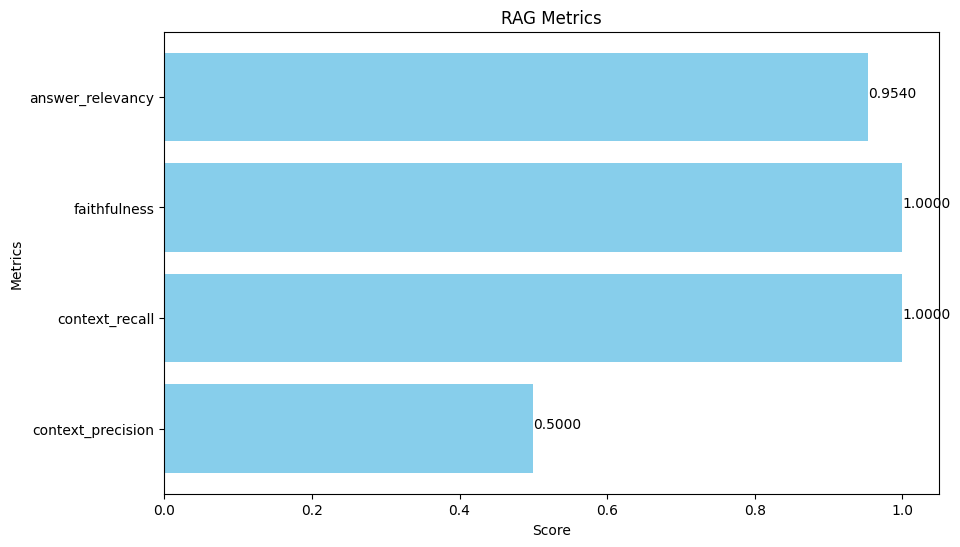

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Select the metrics you want to plot (assuming the first row contains the metrics you want to plot)
metrics = evaluation_results.loc[0, ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].to_dict()

# Extract keys and values from the dictionary
labels = list(metrics.keys())
scores = list(metrics.values())

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, scores, color='skyblue')

# Add the score values to the bars
for index, value in enumerate(scores):
    plt.text(value, index, f'{value:.4f}')

# Add title and labels
plt.title('RAG Metrics')
plt.xlabel('Score')
plt.ylabel('Metrics')

# Show the plot
plt.show()



In [20]:
evaluation_results.columns

Index(['question', 'answer', 'contexts', 'ground_truths', 'context_precision',
       'context_recall', 'faithfulness', 'answer_relevancy'],
      dtype='object')

In [31]:
# import pandas as pd
# # Set display options to show more characters in each column
# pd.set_option('display.max_colwidth', None)
# display(evaluation_results.style.set_properties(**{'text-align': 'left'}))

In [12]:
# Question and Answer

llm_response = generate_response('"What is the termination notice?"')


In [13]:

llm_response['result']

"The termination notice in this agreement refers to a written notice given by either party to end the agreement. This can be done for any reason, with or without cause, and requires a fourteen (14) days' prior written notice. However, the Company can terminate the agreement immediately and without prior notice if the Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement."

### Perfect Answer

## Raptor Data

In [32]:

# Example query
original_query =  "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"

# Augment the query with multiple related questions
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

queries = [original_query] + augmented_queries

# Retrieve documents using the expanded queries
retrieved_documents, retrieved_embeddings = query_relevant_documents(queries, vector_store)

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)


# Retrieve embeddings for visualization
original_query_embedding = embeddings_model.embed_query(original_query)
augmented_query_embeddings = embeddings_model.embed_documents(augmented_queries)

project_original_query = project_embeddings([original_query_embedding], umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

# Flatten the list of embeddings
result_embeddings = [embedding for sublist in retrieved_embeddings for embedding in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


content='Original question: What should I include in a freelance contract?\n\n1. What are the essential clauses to include in a freelance contract?\n2. How can I protect my rights as a freelancer in the contract?\n3. What should the payment terms look like in a freelance contract?\n4. How can I handle dispute resolution in a freelance contract?\n5. Should I include a confidentiality clause in my freelance contract?' response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 100, 'total_tokens': 181}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-7f59f8b1-5197-412e-8757-3b9a58b4ea50-0' usage_metadata={'input_tokens': 100, 'output_tokens': 81, 'total_tokens': 181}
Original question: What should I include in a freelance contract?

1. What are the essential clauses to include in a freelance contract?
2. How can I protect my rights as a freelancer in the contract?
3. What should the payment terms look like in a f

100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


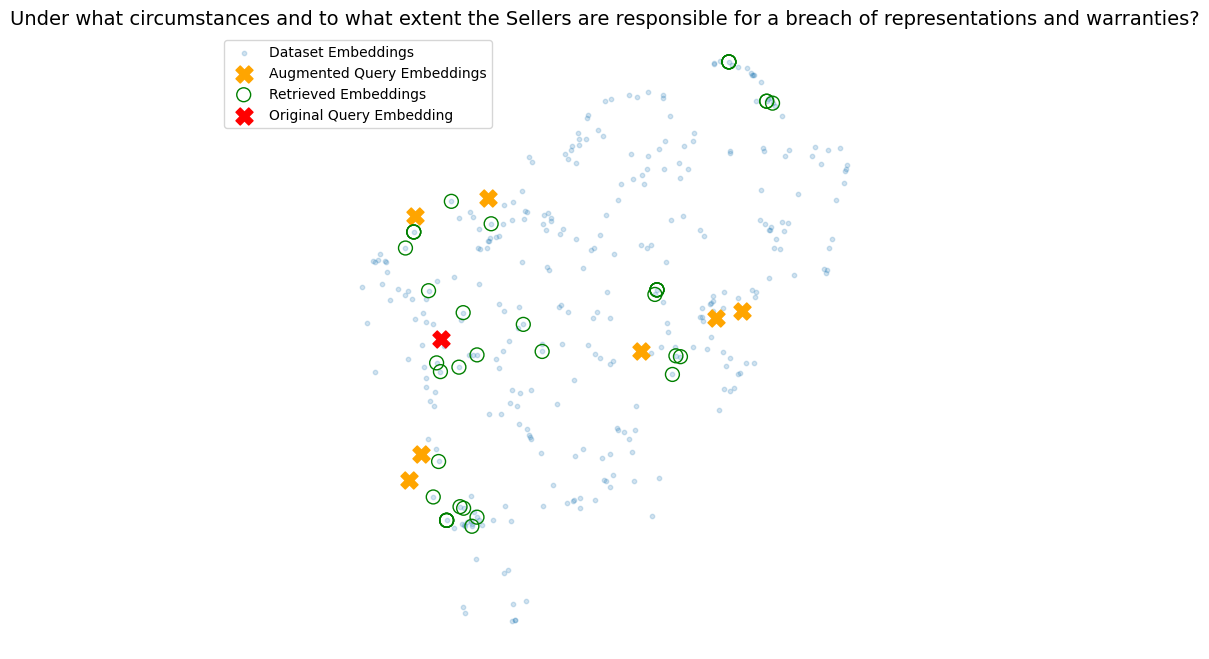

In [33]:

# Plot the projected queries and retrieved documents in the embedding space
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.2, label='Dataset Embeddings')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange', label='Augmented Query Embeddings')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g', label='Retrieved Embeddings')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r', label='Original Query Embedding')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}', fontsize=14)
plt.legend()
plt.axis('off')
plt.show()


In [34]:


# Load the evaluation dataset
evaluation_data = load_evaluation_data('raptor_evaluation_data.json')

  
responses = generate_responses(evaluation_data)

# Prepare the dataset
dataset = prepare_dataset(responses)

# Verify the dataset
print(dataset)

# Evaluate the dataset
evaluation_results = evaluate_dataset(dataset)

# Print the evaluation results
print(evaluation_results)


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 14
})
evaluating with [context_precision]


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


evaluating with [faithfulness]


100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


evaluating with [answer_relevancy]


100%|██████████| 1/1 [00:18<00:00, 18.84s/it]


                                                                                                                                                                                                               question  \
0                                                                                               Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?   
1   Would the Sellers be responsible if after the closing it is determined that there were inaccuracies in the representation provided by them where such inaccuracies are the result of the Sellers’ gross negligence?   
2                                                                                                                                                                                        How much is the escrow amount?   
3                                                                                                                           

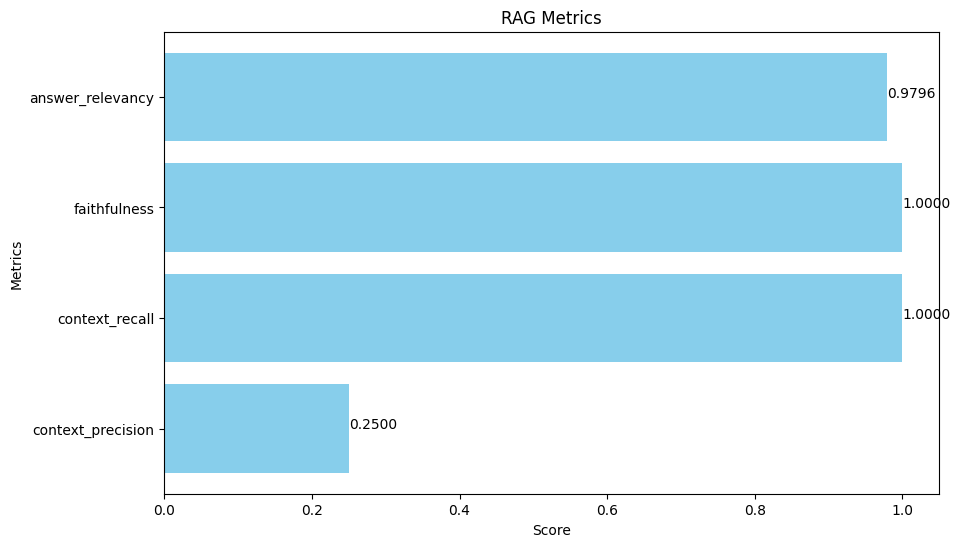

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Select the metrics you want to plot (assuming the first row contains the metrics you want to plot)
metrics = evaluation_results.loc[4, ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].to_dict()

# Extract keys and values from the dictionary
labels = list(metrics.keys())
scores = list(metrics.values())

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, scores, color='skyblue')

# Add the score values to the bars
for index, value in enumerate(scores):
    plt.text(value, index, f'{value:.4f}')

# Add title and labels
plt.title('RAG Metrics')
plt.xlabel('Score')
plt.ylabel('Metrics')

# Show the plot
plt.show()



In [41]:
# Question and Answer

llm_response = generate_response('What is the purpose of the escrow?')

llm_response['result']

'The purpose of the escrow in this context is to hold the Escrow Amount deposited by the Buyer at closing. This amount is held in a separate account and is used to satisfy any obligations of the Company Securityholders as provided in the agreement. The escrow also serves as a means to adjust the purchase price in case of any disputes or recalculations. The funds in the escrow account can be disbursed to either the Company Securityholders or the Buyer in accordance with the terms of the Escrow Agreement.'

### Wowwww Amazing